# Классификация: Decision Trees → RandomForest → Boosting

Обучим и сравним **три семейства моделей** для бинарной классификации:
- **Decision Tree (дерево решений)**
- **Random Forest (случайный лес)**
- **Boosting (градиентный бустинг)**

Разберём:
- почему деревья часто сильны “из коробки”
- **feature importance** и **overfitting**
- **cross‑validation** + **GridSearchCV**
- сравнение метрик и выбор лучшей модели

В конце — **10 заданий** в формате: **задание → подсказка → код с пропусками**.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import (
    confusion_matrix, classification_report,
    precision_score, recall_score, f1_score, roc_auc_score, roc_curve
)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import joblib

np.set_printoptions(precision=4, suppress=True)
sns.set_context("notebook")
print("Ready!")

Ready!


# 1) Датасет

Чтобы урок запускался у всех, берём встроенный датасет **Breast Cancer Wisconsin**:
- задача: предсказать класс опухоли (доброкачественная/злокачественная)
- `target` бинарный: 0/1
- признаки — числовые

> В реальном проекте вы замените это на свой Kaggle CSV. Пайплайн и логика останутся теми же.


In [2]:
data = load_breast_cancer(as_frame=True)
df = data.frame.copy()
df.rename(columns={"target": "target"}, inplace=True)

# Переименуем target в понятное имя (не обязательно, но удобно)
# 0 = malignant, 1 = benign (в этом датасете)
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [3]:
print("Shape:", df.shape)
print("Target distribution:")
print(df["target"].value_counts())
print("Target share:")
print(df["target"].value_counts(normalize=True))

# Имена классов для красоты в отчётах
class_names = data.target_names
print("Class names:", class_names)

Shape: (569, 31)
Target distribution:
target
1    357
0    212
Name: count, dtype: int64
Target share:
target
1    0.627417
0    0.372583
Name: proportion, dtype: float64
Class names: ['malignant' 'benign']


# 2) Мини‑EDA

Зачем:
- увидеть баланс классов (сильно ли перекос?)
- понять масштабы признаков
- посмотреть корреляции (на уровне “чувства данных”)

Важно: деревья **не требуют StandardScaler**, потому что они делают разбиения по порогам.


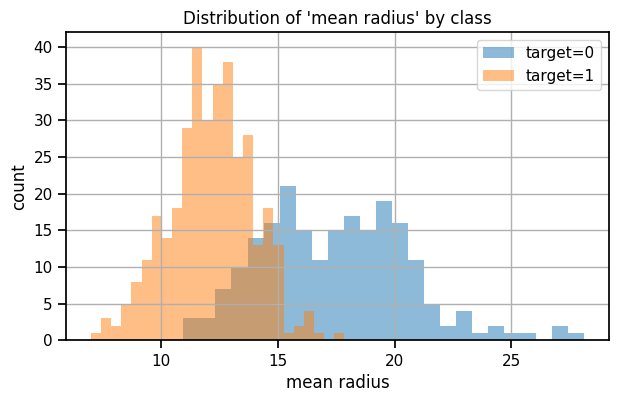

,corr,abs_corr
worst concave points,-0.793566,0.793566
worst perimeter,-0.782914,0.782914
mean concave points,-0.776614,0.776614
worst radius,-0.776454,0.776454
mean perimeter,-0.742636,0.742636
worst area,-0.733825,0.733825
mean radius,-0.730029,0.730029
mean area,-0.708984,0.708984
mean concavity,-0.696360,0.696360
worst concavity,-0.659610,0.659610


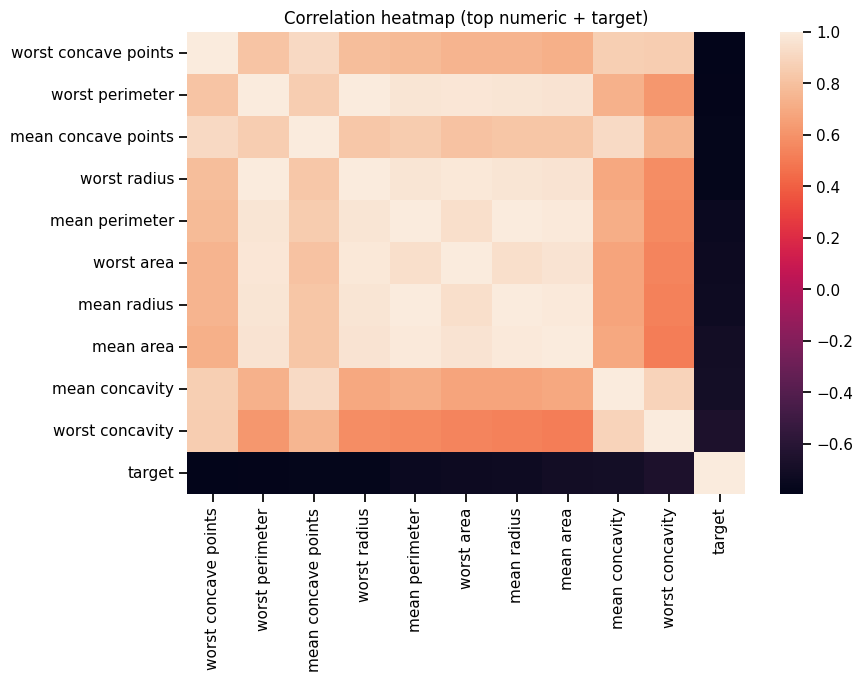

In [4]:
# 2.1) Гистограмма одного признака по классам
col = "mean radius"

plt.figure(figsize=(7,4))
for t in [0, 1]:
    subset = df[df["target"] == t][col]
    plt.hist(subset, bins=25, alpha=0.5, label=f"target={t}")
plt.title(f"Distribution of '{col}' by class")
plt.xlabel(col)
plt.ylabel("count")
plt.grid(True)
plt.legend()
plt.show()

# 2.2) Корреляции (топ-10 по связи с target)
num_cols = df.select_dtypes(include="number").columns.tolist()
num_cols = [c for c in num_cols if c != "target"]

corr = df[num_cols + ["target"]].corr(numeric_only=True)["target"].drop("target")
top = corr.abs().sort_values(ascending=False).head(10)
display(pd.DataFrame({"corr": corr.loc[top.index], "abs_corr": top.values}).sort_values("abs_corr", ascending=False))

# 2.3) Heatmap для топовых признаков
cols_hm = top.index.tolist() + ["target"]
plt.figure(figsize=(9,6))
sns.heatmap(df[cols_hm].corr(numeric_only=True), annot=False)
plt.title("Correlation heatmap (top numeric + target)")
plt.show()

# 3) Train/Test split

Разделяем данные:
- `X` — признаки
- `y` — target

Используем `stratify=y`, чтобы доли классов в train/test были похожи.


In [5]:
X = df.drop(columns=["target"])
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Train share:", y_train.value_counts(normalize=True).to_dict())
print("Test  share:", y_test.value_counts(normalize=True).to_dict())

Train: (426, 30) Test: (143, 30)
Train share: {1: 0.6267605633802817, 0: 0.3732394366197183}
Test  share: {1: 0.6293706293706294, 0: 0.3706293706293706}


# 4) Почему деревья часто “сильны из коробки”

Дерево решений:
- выбирает признак и порог, чтобы “лучше разделить классы”
- повторяет это рекурсивно, строя структуру “вопрос → ветка”

Почему удобно:
- работает с нелинейностями и взаимодействиями признаков
- не требует масштабирования (StandardScaler)
- легко объяснять (в простых случаях)
- умеет работать с “разными масштабами” признаков

Но есть проблема: **переобучение**.
Если дерево слишком глубокое, оно может “запомнить” train.


## 4.1) Preprocessing (минимальный)

Здесь все признаки числовые. Мы сделаем только `SimpleImputer(median)` на случай пропусков.
Это хорошая привычка для Kaggle‑датасетов.

> Для деревьев scaler не нужен.


In [6]:
num_features = X_train.columns.tolist()

preprocess = ColumnTransformer([
    ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), num_features),
], remainder="drop")

preprocess

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['mean radius', 'mean texture',
                                  'mean perimeter', 'mean area',
                                  'mean smoothness', 'mean compactness',
                                  'mean concavity', 'mean concave points',
                                  'mean symmetry', 'mean fractal dimension',
                                  'radius error', 'texture error',
                                  'perimeter error', 'area error',
                                  'smoothness error', 'compactness error',
                                  'concavity error', 'concave points error',
                                  'symmetry error', 'fractal dimension error',
                                  'worst radius', 'worst texture',
                                  'worst perimeter', 'worst area',
                                  'worst smoothness', 'worst compactness',
                                  'worst concavity', 'worst concave points',
                                  'worst symmetry',
                                  'worst fractal dimension'])])

## 4.2) DecisionTreeClassifier: baseline

Обучим дерево и посмотрим качество.


In [7]:
tree_clf = Pipeline([
    ("preprocess", preprocess),
    ("model", DecisionTreeClassifier(random_state=42))
])

tree_clf.fit(X_train, y_train)

pred = tree_clf.predict(X_test)
proba = tree_clf.predict_proba(X_test)[:, 1]

print("Precision:", precision_score(y_test, pred))
print("Recall   :", recall_score(y_test, pred))
print("F1       :", f1_score(y_test, pred))
print("ROC-AUC  :", roc_auc_score(y_test, proba))

print("\nConfusion matrix:\n", confusion_matrix(y_test, pred))
print("\nReport:\n", classification_report(y_test, pred, digits=4))

Precision: 0.9540229885057471
Recall   : 0.9222222222222223
F1       : 0.9378531073446328
ROC-AUC  : 0.9233752620545074

Confusion matrix:
 [[49  4]
 [ 7 83]]

Report:
               precision    recall  f1-score   support

           0     0.8750    0.9245    0.8991        53
           1     0.9540    0.9222    0.9379        90

    accuracy                         0.9231       143
   macro avg     0.9145    0.9234    0.9185       143
weighted avg     0.9247    0.9231    0.9235       143



## 4.3) Переобучение: глубина дерева

Покажем идею overfitting:
- на маленькой глубине дерево может **недообучаться**
- на большой глубине дерево часто **переобучается** (train ≫ test)

Сделаем цикл по `max_depth` и сравним train/test F1.


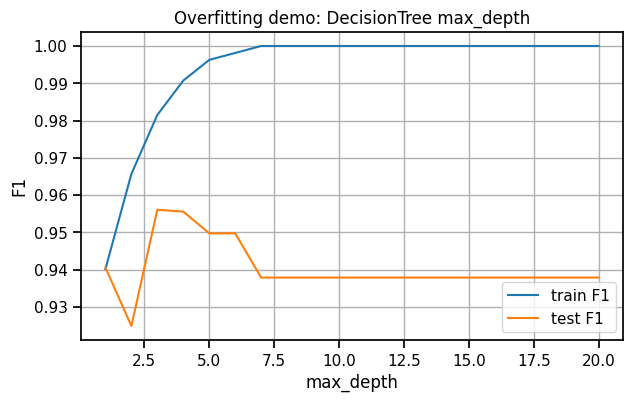

Best depth by test-F1 (for demo only): 3


In [8]:
depths = list(range(1, 21))
train_f1 = []
test_f1 = []

for d in depths:
    model_d = Pipeline([
        ("preprocess", preprocess),
        ("model", DecisionTreeClassifier(max_depth=d, random_state=42))
    ])
    model_d.fit(X_train, y_train)

    pred_train = model_d.predict(X_train)
    pred_test  = model_d.predict(X_test)

    train_f1.append(f1_score(y_train, pred_train))
    test_f1.append(f1_score(y_test, pred_test))

plt.figure(figsize=(7,4))
plt.plot(depths, train_f1, label="train F1")
plt.plot(depths, test_f1, label="test F1")
plt.title("Overfitting demo: DecisionTree max_depth")
plt.xlabel("max_depth")
plt.ylabel("F1")
plt.grid(True)
plt.legend()
plt.show()

best_depth = depths[int(np.argmax(test_f1))]
print("Best depth by test-F1 (for demo only):", best_depth)

## 4.4) Feature importance

У дерева есть `feature_importances_` — оценка “важности” признаков в разбиениях.
Это **не всегда** “истинная причинность”, но как быстрый анализ — полезно.

Покажем топ‑10.


,0
worst radius,0.695463
worst concave points,0.116844
worst texture,0.061358
texture error,0.046310
worst concavity,0.017403
mean concave points,0.013547
area error,0.012069
worst symmetry,0.011373
worst area,0.009031
mean radius,0.007526


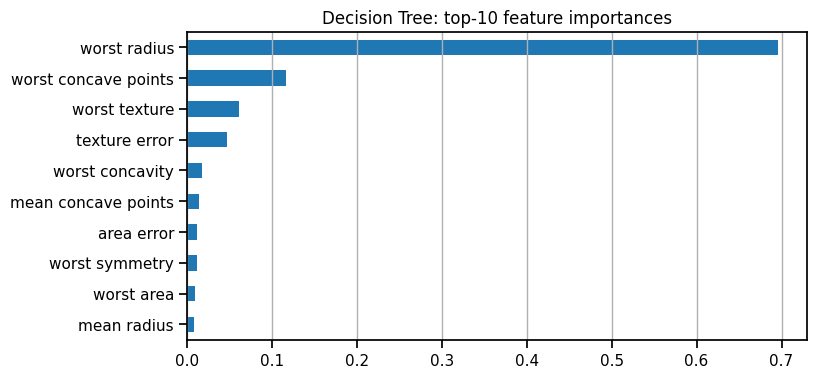

In [9]:
# Достанем "внутреннее" дерево из пайплайна
tree_model = tree_clf.named_steps["model"]
importances = pd.Series(tree_model.feature_importances_, index=num_features).sort_values(ascending=False)

display(importances.head(15))

plt.figure(figsize=(8,4))
importances.head(10).iloc[::-1].plot(kind="barh")
plt.title("Decision Tree: top-10 feature importances")
plt.grid(True, axis="x")
plt.show()

# 5) RandomForestClassifier

Случайный лес = много деревьев + “случайность”:
- обучаем много деревьев на разных подвыборках данных (bagging)
- в каждом узле дерево видит **случайный поднабор признаков**

Почему это часто сильно “из коробки”:
- одно дерево нестабильно (высокая дисперсия)
- лес **усредняет** много деревьев → дисперсия падает → качество на test растёт
- меньше риска сильного overfitting, чем у одного глубокого дерева (но всё равно возможно)

Деревьям/лесу scaler не нужен.


In [10]:
rf_clf = Pipeline([
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=400,
        random_state=42,
        n_jobs=-1,
        min_samples_leaf=2
    ))
])

rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
proba = rf_clf.predict_proba(X_test)[:, 1]

print("Precision:", precision_score(y_test, pred))
print("Recall   :", recall_score(y_test, pred))
print("F1       :", f1_score(y_test, pred))
print("ROC-AUC  :", roc_auc_score(y_test, proba))
print("\nConfusion matrix:\n", confusion_matrix(y_test, pred))

Precision: 0.9565217391304348
Recall   : 0.9777777777777777
F1       : 0.967032967032967
ROC-AUC  : 0.9939203354297694

Confusion matrix:
 [[49  4]
 [ 2 88]]


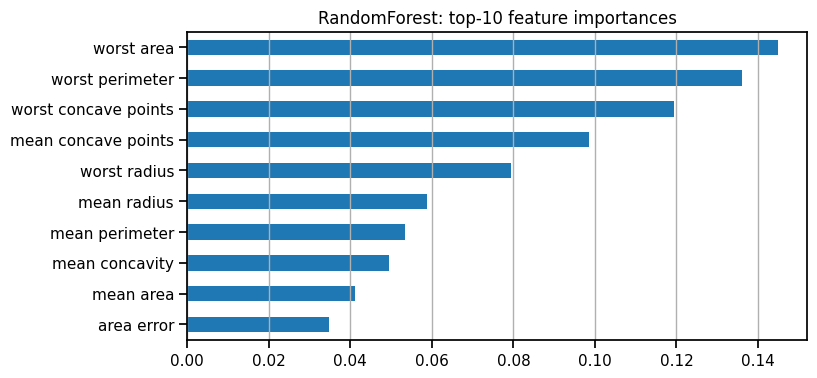

In [11]:
# Feature importance у леса (обычно стабильнее, чем у одного дерева)
rf_model = rf_clf.named_steps["model"]
rf_importances = pd.Series(rf_model.feature_importances_, index=num_features).sort_values(ascending=False)

plt.figure(figsize=(8,4))
rf_importances.head(10).iloc[::-1].plot(kind="barh")
plt.title("RandomForest: top-10 feature importances")
plt.grid(True, axis="x")
plt.show()

# 6) Boosting (GradientBoostingClassifier)

Идея бустинга:
- обучаем модели **последовательно**
- каждая следующая старается исправить ошибки предыдущих
- часто даёт высокое качество при аккуратной настройке

`GradientBoostingClassifier` — классический вариант в sklearn.
(Это не XGBoost, но идея близка.)


In [12]:
gb_clf = Pipeline([
    ("preprocess", preprocess),
    ("model", GradientBoostingClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,   # глубина деревьев (слабые модели)
        random_state=42
    ))
])

gb_clf.fit(X_train, y_train)
pred = gb_clf.predict(X_test)
proba = gb_clf.predict_proba(X_test)[:, 1]

print("Precision:", precision_score(y_test, pred))
print("Recall   :", recall_score(y_test, pred))
print("F1       :", f1_score(y_test, pred))
print("ROC-AUC  :", roc_auc_score(y_test, proba))
print("\nConfusion matrix:\n", confusion_matrix(y_test, pred))

Precision: 0.9468085106382979
Recall   : 0.9888888888888889
F1       : 0.967391304347826
ROC-AUC  : 0.9928721174004194

Confusion matrix:
 [[48  5]
 [ 1 89]]


# 7) Cross‑validation (CV) сравнение моделей

Почему CV важно:
- одно train/test разбиение может дать “случайно хороший/плохой” результат
- CV даёт более устойчивую оценку

Используем `StratifiedKFold(5)` и метрику `F1` (можно заменить на ROC-AUC).


In [13]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "Tree": Pipeline([("preprocess", preprocess), ("model", DecisionTreeClassifier(random_state=42))]),
    "RF":   Pipeline([("preprocess", preprocess), ("model", RandomForestClassifier(
        n_estimators=400, random_state=42, n_jobs=-1, min_samples_leaf=2
    ))]),
    "GB":   Pipeline([("preprocess", preprocess), ("model", GradientBoostingClassifier(
        n_estimators=300, learning_rate=0.05, max_depth=3, random_state=42
    ))]),
}

rows = []
for name, m in models.items():
    scores = cross_val_score(m, X_train, y_train, cv=cv, scoring="f1")
    rows.append({"model": name, "cv_f1_mean": scores.mean(), "cv_f1_std": scores.std()})
    print(f"{name:5s} | mean={scores.mean():.4f} std={scores.std():.4f} | scores={np.round(scores, 4)}")

cv_table = pd.DataFrame(rows).sort_values("cv_f1_mean", ascending=False)
cv_table

Tree  | mean=0.9396 std=0.0129 | scores=[0.9541 0.9245 0.9423 0.9245 0.9524]
RF    | mean=0.9644 std=0.0139 | scores=[0.963  0.9524 0.9533 0.963  0.9907]
GB    | mean=0.9642 std=0.0185 | scores=[0.9541 0.9815 0.9524 0.9423 0.9907]


,model,cv_f1_mean,cv_f1_std
1,RF,0.964446,0.013869
2,GB,0.964191,0.018541
0,Tree,0.939575,0.012931


# 8) GridSearchCV (минимально)

Покажем, как настраивать модели через сетку гиперпараметров.

Мы будем искать по `F1` (на CV):
- Tree: `max_depth`, `min_samples_leaf`
- RF: `n_estimators`, `max_depth`, `min_samples_leaf`, `max_features`
- GB: `n_estimators`, `learning_rate`, `max_depth`

⚠️ Сетки маленькие, чтобы работало быстро на обычных ноутбуках.


In [14]:
# 8.1) DecisionTree grid
tree_pipe = Pipeline([("preprocess", preprocess), ("model", DecisionTreeClassifier(random_state=42))])
tree_grid = {
    "model__max_depth": [2, 3, 4, 5, 7, None],
    "model__min_samples_leaf": [1, 2, 5, 10],
}

gs_tree = GridSearchCV(tree_pipe, tree_grid, cv=cv, scoring="f1", n_jobs=-1)
gs_tree.fit(X_train, y_train)

print("Best Tree params:", gs_tree.best_params_)
print("Best Tree CV F1 :", gs_tree.best_score_)

Best Tree params: {'model__max_depth': 3, 'model__min_samples_leaf': 5}
Best Tree CV F1 : 0.9516748522573766


In [ ]:
# 8.2) RandomForest grid
rf_pipe = Pipeline([("preprocess", preprocess), ("model", RandomForestClassifier(random_state=42, n_jobs=-1))])
rf_grid = {
    "model__n_estimators": [200, 500],
    "model__max_depth": [None, 4, 6],
    "model__min_samples_leaf": [1, 2, 5],
    "model__max_features": ["sqrt", 0.6, 1.0],
}

gs_rf = GridSearchCV(rf_pipe, rf_grid, cv=cv, scoring="f1", n_jobs=-1)
gs_rf.fit(X_train, y_train)

print("Best RF params:", gs_rf.best_params_)
print("Best RF CV F1 :", gs_rf.best_score_)

In [ ]:
# 8.3) GradientBoosting grid
gb_pipe = Pipeline([("preprocess", preprocess), ("model", GradientBoostingClassifier(random_state=42))])
gb_grid = {
    "model__n_estimators": [100, 300, 600],
    "model__learning_rate": [0.03, 0.05, 0.1],
    "model__max_depth": [2, 3, 4],
}

gs_gb = GridSearchCV(gb_pipe, gb_grid, cv=cv, scoring="f1", n_jobs=-1)
gs_gb.fit(X_train, y_train)

print("Best GB params:", gs_gb.best_params_)
print("Best GB CV F1 :", gs_gb.best_score_)

# 9) Выбор лучшей модели, тест на test и сохранение

Логика:
- выбираем лучшую по CV (GridSearch)
- обучаем на train
- измеряем на test один раз
- сохраняем `joblib.dump`


In [ ]:
candidates = [
    ("Tree(Grid)", gs_tree.best_estimator_, gs_tree.best_score_),
    ("RF(Grid)",   gs_rf.best_estimator_,   gs_rf.best_score_),
    ("GB(Grid)",   gs_gb.best_estimator_,   gs_gb.best_score_),
]
candidates = sorted(candidates, key=lambda x: x[2], reverse=True)
best_name, best_model, best_cv = candidates[0]

print("Selected:", best_name, "| CV F1:", best_cv)

best_model.fit(X_train, y_train)
pred = best_model.predict(X_test)
proba = best_model.predict_proba(X_test)[:, 1]

print("TEST Precision:", precision_score(y_test, pred))
print("TEST Recall   :", recall_score(y_test, pred))
print("TEST F1       :", f1_score(y_test, pred))
print("TEST ROC-AUC  :", roc_auc_score(y_test, proba))
print("\nConfusion matrix:\n", confusion_matrix(y_test, pred))

# ROC curve (optional quick look)
fpr, tpr, thr = roc_curve(y_test, proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr)
plt.title(f"ROC curve — {best_name}")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.grid(True)
plt.show()

# Save / load
MODEL_PATH = "best_tree_rf_gb_classifier.joblib"
joblib.dump(best_model, MODEL_PATH)
print("Saved:", MODEL_PATH)

loaded = joblib.load(MODEL_PATH)
print("Loaded type:", type(loaded))

# sanity check
p1 = best_model.predict_proba(X_test.head(5))[:, 1]
p2 = loaded.predict_proba(X_test.head(5))[:, 1]
print("proba original:", np.round(p1, 4))
print("proba loaded  :", np.round(p2, 4))

---
# 10 заданий (проверка усвоения)

Формат:
**Задание → подсказка → код с пропусками (`_____`)**

Правило: дополняйте код, не переписывайте всё.


## Задание 1

**Задание:** Сделайте train/test split для X,y (test_size=0.3) с stratify=y. Выведите доли классов.

**Подсказка:** train_test_split(..., stratify=y)


In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=[_____])
y = df[_____]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=_____,
    random_state=42,
    stratify=_____
)

print("train share:", y_train.value_counts(normalize=True).to_dict())
print("test  share:", y_test.value_counts(normalize=True).to_dict())

## Задание 2

**Задание:** Обучите DecisionTreeClassifier(random_state=42) и посчитайте precision/recall/F1 на test.

**Подсказка:** model.fit(X_train,y_train); pred=model.predict(X_test)


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score

dt = DecisionTreeClassifier(random_state=_____)
dt.fit(_____, _____)

pred = dt.predict(_____)

print("precision:", precision_score(_____, _____))
print("recall   :", recall_score(_____, _____))
print("f1       :", f1_score(_____, _____))

## Задание 3

**Задание:** Сделайте цикл по max_depth=1..12 и постройте train/test F1 для дерева.

**Подсказка:** используйте f1_score и plt.plot


In [ ]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

depths = list(range(1, _____))
train_f1, test_f1 = [], []

for d in depths:
    dt = DecisionTreeClassifier(max_depth=_____, random_state=42)
    dt.fit(X_train, y_train)
    train_f1.append(f1_score(y_train, dt.predict(_____)))
    test_f1.append(f1_score(y_test, dt.predict(_____)))

plt.figure(figsize=(7,4))
plt.plot(depths, train_f1, label="train")
plt.plot(depths, test_f1, label="test")
plt.title("DecisionTree overfitting by depth")
plt.xlabel("max_depth")
plt.ylabel("F1")
plt.grid(True)
plt.legend()
plt.show()

## Задание 4

**Задание:** После обучения дерева выведите топ-5 важнейших признаков по feature_importances_.

**Подсказка:** pd.Series(dt.feature_importances_, index=X.columns).sort_values(ascending=False)


In [ ]:
import pandas as pd

imp = pd.Series(dt.feature_importances_, index=_____)      .sort_values(ascending=_____)

print(imp.head(_____))

## Задание 5

**Задание:** Обучите RandomForestClassifier(n_estimators=300, min_samples_leaf=2) и посчитайте F1 на test.

**Подсказка:** RandomForestClassifier(..., n_jobs=-1, random_state=42)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

rf = RandomForestClassifier(
    n_estimators=_____,
    min_samples_leaf=_____,
    random_state=42,
    n_jobs=_____
)
rf.fit(_____, _____)

pred = rf.predict(_____)
print("F1:", f1_score(_____, _____))

## Задание 6

**Задание:** Постройте barh-график топ-10 важностей признаков у случайного леса.

**Подсказка:** imp.head(10).iloc[::-1].plot(kind='barh')


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

rf_imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8,4))
rf_imp.head(_____)      .iloc[_____]      .plot(kind=_____)

plt.title("RandomForest top feature importances")
plt.grid(True, axis="x")
plt.show()

## Задание 7

**Задание:** Обучите GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, max_depth=3) и посчитайте ROC-AUC.

**Подсказка:** roc_auc_score(y_test, proba)


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

gb = GradientBoostingClassifier(
    n_estimators=_____,
    learning_rate=_____,
    max_depth=_____,
    random_state=42
)
gb.fit(_____, _____)

proba = gb.predict_proba(_____)[:, _____]
print("ROC-AUC:", roc_auc_score(_____, _____))

## Задание 8

**Задание:** Сделайте CV (StratifiedKFold=5) и посчитайте средний F1 для дерева, леса и бустинга.

**Подсказка:** cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')


In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=_____, shuffle=True, random_state=42)

models = {
    "Tree": DecisionTreeClassifier(random_state=42),
    "RF": RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1),
    "GB": GradientBoostingClassifier(random_state=42),
}

for name, m in models.items():
    scores = cross_val_score(_____, X_train, y_train, cv=_____, scoring=_____)
    print(name, "mean F1 =", scores.mean(), "std =", scores.std())

## Задание 9

**Задание:** Сделайте GridSearchCV для RandomForest по max_depth и min_samples_leaf. Выведите best_params_ и best_score_.

**Подсказка:** GridSearchCV(rf, param_grid=..., cv=cv, scoring='f1')


In [ ]:
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)

param_grid = {
    "max_depth": [None, 4, 6],
    "min_samples_leaf": [1, 2, 5],
}

gs = GridSearchCV(_____, param_grid=_____, cv=_____, scoring=_____, n_jobs=-1)
gs.fit(_____, _____)

print("best params:", gs.best_params_)
print("best CV F1 :", gs.best_score_)

## Задание 10

**Задание:** Возьмите best_estimator_ из GridSearch, обучите на train, посчитайте F1 на test и сохраните joblib.

**Подсказка:** joblib.dump(model, 'model.joblib')


In [ ]:
import joblib
from sklearn.metrics import f1_score

best = gs.best_estimator_
best.fit(_____, _____)

pred = best.predict(_____)
print("TEST F1:", f1_score(_____, _____))

joblib.dump(_____, "rf_best.joblib")
loaded = joblib.load("rf_best.joblib")
print("Loaded OK:", type(loaded))